# Semantic Segmentation

### Import frameworks, libraries and modules

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy import io

In [2]:
# Use tf.test.is_built_with_cuda() to validate if TensorFlow was built with CUDA support.
tf.test.is_built_with_cuda()

True

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0],True)

In [4]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Create 2 virtual GPUs with 1GB memory each
#     try:
#         tf.config.set_logical_device_configuration(
#             gpus[0],
#             [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
#              tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
#         logical_gpus = tf.config.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Virtual devices must be set before GPUs have been initialized
#         print(e)

# Download and prepare data

### Download masks

In [5]:
# ## OS ####
path_mask_folder = os.path.pardir+os.sep+'lib'+os.sep+'MASKS'
path_mask_folder

'..\\lib\\MASKS'

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# path_mask_folder = '/content/drive/MyDrive/Diploma/MASKS'

In [8]:
mask_path = []

for root, dirs, files in os.walk(path_mask_folder):
    for file in files:
        path = os.path.join(root,file)
        mask_path.append(path)
len(mask_path)

1004

### Download images

In [9]:
### OS ###
path_images_folder = os.path.pardir+os.sep+'lib'+os.sep+'IMAGES'
path_images_folder

'..\\lib\\IMAGES'

In [10]:
# path_images_folder = '/content/drive/MyDrive/Diploma/IMAGES'

In [11]:
image_path_ = []

for root, dirs, files in os.walk(path_images_folder):
    for file in files:
        path = os.path.join(root,file)
        image_path_.append(path)
len(image_path_)

2097

### Sorting the masks to match the image

In [12]:
mask_path.sort()

In [13]:
image_path_.sort()

### Separating the training set associated with the masks

In [14]:
image_path = image_path_[:len(mask_path)]

In [15]:
len(image_path)

1004

### Reading masks and images

In [16]:
images = []

for path in image_path:
    file = tf.io.read_file(path)
    image = tf.image.decode_png(file, channels=3, dtype=tf.uint8)
    images.append(image)

masks = []

for path in mask_path:
    file = tf.io.read_file(path)
    mask = tf.image.decode_png(file, channels=1, dtype=tf.uint8)
    masks.append(mask)

### Sample few images and visualize

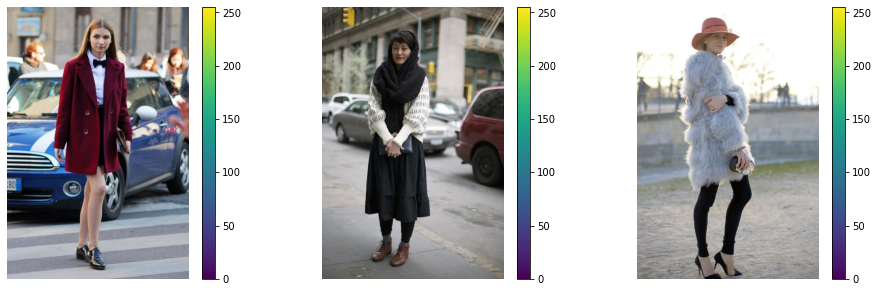

In [17]:
plt.figure(figsize=(16,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = images[60+i]
    plt.imshow(img)
    plt.colorbar()
    plt.axis('off')
plt.show()

Изображения ярлыков имеют 59 сегментированных классов, 
соответствующих таким классам, как волосы, сумка, рубашка, обувь, кожа, 
солнцезащитные очки и кепка.

### Sample corresponding masks and visualize

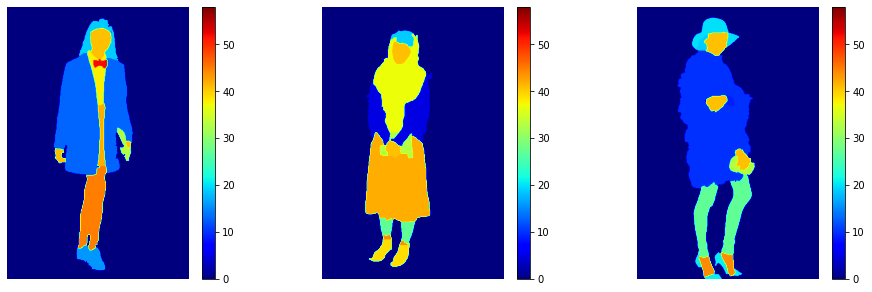

In [18]:
norm = mpl.colors.Normalize(vmin=0, vmax=58)

plt.figure(figsize=(16,5))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = masks[60+i]
    plt.imshow(tf.squeeze(img), cmap='jet', norm=norm)
    plt.colorbar()
    plt.axis('off')
plt.show()

### Download masks label

In [19]:
### OS ####
path_pixel_level = os.path.pardir+os.sep+'lib'+os.sep+'clothing-co-parsing' \
                                                        +os.sep+'annotations'+os.sep+'pixel-level'
path_pixel_level

'..\\lib\\clothing-co-parsing\\annotations\\pixel-level'

In [20]:
# label_list = pd.read_csv('/content/drive/MyDrive/Diploma/labels.csv')
# label_list.head()

In [21]:
pixel_level_of_images = []

for root, dirs, files in os.walk(path_pixel_level):
    pixel_level_of_images.append(len(files))
    
segmentations = []

for i in range(1,pixel_level_of_images[0]+1):
    
    url = path_pixel_level+os.sep+ '%04d.mat'%(i)
    
    # Чтение файлов .ma
    file = io.loadmat(url)
    mask = tf.convert_to_tensor(file['groundtruth'])
    # resize ожидает 3D-изображения, но мы получили 2D-изображение в оттенках серого
    mask = tf.expand_dims(mask,-1)
    mask = tf.image.resize_with_crop_or_pad(mask,825,550)
    segmentations.append(mask)
    
list_unique_mask = np.unique(tf.squeeze(segmentations))

if min(list_unique_mask)==0:
    num_mask = max(list_unique_mask)+1

In [22]:
# num_mask = label_list.shape[0]
# num_mask

## Build Downstack with a Pre-trained CNN

In [23]:
DenseNet121_base = keras.applications.DenseNet121(input_shape=[256,256,3], 
                                      include_top=False, 
                                      weights='imagenet')

### How many layers does this model have?

In [24]:
# len(DenseNet121_base.layers)

Нам нужно определить подходящие слои, вывод которых будет использоваться для пропуска соединений.  
Выбираем слои активации ReLU для каждого размера карты функций, то есть 4, 8, 16, 32 и 64, необходимых для пропуска подключений.

In [25]:
# DenseNet121_base.summary()

In [26]:
skip_names = []
for layer in tuple(DenseNet121_base.layers):
        layer_type = type(layer).__name__
        if hasattr(layer, 'activation'):
            if layer_type != "Conv2D":   
                if not layer.name.__contains__('block'):
                    skip_names.append(layer.name) 

In [27]:
skip_names

['conv1/relu', 'pool2_relu', 'pool3_relu', 'pool4_relu', 'relu']

### Obtain the outputs of these layers.

In [28]:
skip_outputs = [] 

for name in skip_names:
    relu = DenseNet121_base.get_layer(name).output
    print('{} : {}'.format(name, relu.shape))
    skip_outputs.append(relu)

conv1/relu : (None, 128, 128, 64)
pool2_relu : (None, 64, 64, 256)
pool3_relu : (None, 32, 32, 512)
pool4_relu : (None, 16, 16, 1024)
relu : (None, 8, 8, 1024)


### Build the downstack with the above layers. 

In [29]:
downstack = keras.Model(inputs=DenseNet121_base.input,
                       outputs=skip_outputs)
# freeze the downstack layers
downstack.trainable = False

# Build Upstack

### Build the up stack using  pix2pix

In [30]:
# pip install -q git+https://github.com/tensorflow/examples.git

In [31]:
from tensorflow_examples.models.pix2pix import pix2pix

In [32]:
# Four upstack layers for upsampling sizes 
# 4->8, 8->16, 16->32, 32->64 
up_stack = [pix2pix.upsample(1024,3),
          pix2pix.upsample(512,3),
          pix2pix.upsample(256,3),
          pix2pix.upsample(128,3)]

In [33]:
up_stack[0].layers

# Build U-Net model with skip-connections

In [34]:
OUTPUT_CHANNELS = 3

In [35]:
tf.debugging.set_log_device_placement(True)
 
def Model(up_stack, downsample):



    inputs = keras.layers.Input(shape=[256,256,3])

    down = downstack(inputs)
    out = down[-1]

    # prepare skip-connections
    skips = reversed(down[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        out = up(out)
        out = tf.keras.layers.Concatenate()([out, skip])

    initializer = tf.random_normal_initializer(0., 0.02)
    # image 128 by 128 with 59 classes
    out = keras.layers.Conv2DTranspose(num_mask, OUTPUT_CHANNELS,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            activation='tanh')(out)  # (batch_size, 256, 256, 3)

    model = tf.keras.Model(inputs=inputs, outputs=out)

    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy']) 

    return model

In [36]:
model = Model(up_stack, downstack)

### Let's plot our model

In [37]:
# keras.utils.plot_model(unet, show_shapes=True)

# Data Preprocessing

In [38]:
images[0].shape, masks[0].shape

(TensorShape([825, 550, 3]), TensorShape([825, 550, 1]))

### Resize data as the model expects. 

In [39]:
def resize_image(image):
    # scale the image
    image = tf.cast(image, tf.float32)
    image = image/255.0
    # resize image
    image = tf.image.resize(image, (256,256))
    return image

def resize_mask(mask):
    # resize the mask
    mask = tf.image.resize(mask, (256,256))
    mask = tf.cast(mask, tf.uint8)
    return mask    

In [40]:
X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks]
len(X), len(y)

(1004, 1004)

In [41]:
images[0].dtype, masks[0].dtype, X[0].dtype, y[0].dtype

(tf.uint8, tf.uint8, tf.float32, tf.uint8)

### Visualize a resized image and a resized mask

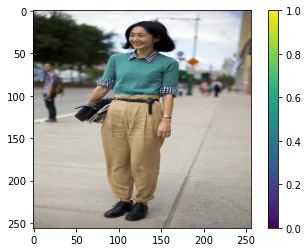

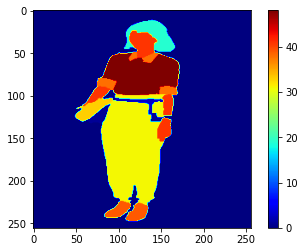

In [42]:
# plot an image
plt.imshow(X[57])
plt.colorbar()
plt.show()

#plot a mask
plt.imshow(tf.squeeze(y[57]), cmap='jet')
plt.colorbar()
plt.show()

# Split Data for training and validation

Разделим данные на набор для обучения и проверки в соотношении 80/20.  
Обвернем данные в  объекты TensorFlow Dataset для обучающих и проверочных наборов, чтобы упростить дальнейшую обработку данных.

In [43]:
from sklearn.model_selection import train_test_split
# split data into 80/20 ratio
train_X, val_X,train_y, val_y = train_test_split(X, y, test_size=0.2, 
                                                      random_state=0
                                                     )
# С помощью tf.data.Dataset.from_tensor_slices() метода мы можем получить срезы массива
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)

train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)

# verify the shapes and data types
train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))

In [44]:
len(list(val_X.as_numpy_iterator()))

201

# Data Augmentation 

У нас меньше данных (всего 800 примеров в обучающей выборке), которых недостаточно для глубокого обучения. Следовательно, мы должны увеличить объем обучающих данных, выполняя приращения данных. Определим функции для увеличения данных.

In [45]:
# def brightness(img, mask):
#     # adjust brightness of image
#     # don't alter in mask
#     img = tf.image.adjust_brightness(img, 0.1)
#     return img, mask

# def gamma(img, mask):
#     # adjust gamma of image
#     # don't alter in mask
#     img = tf.image.adjust_gamma(img, 0.1)
#     return img, mask

# def hue(img, mask):
#     # adjust hue of image
#     # don't alter in mask
#     img = tf.image.adjust_hue(img, -0.1)
#     return img, mask

# def crop(img, mask):
#     # crop both image and mask identically
#     img = tf.image.central_crop(img, 0.7)
#     # resize after cropping
#     img = tf.image.resize(img, (256,256))
#     mask = tf.image.central_crop(mask, 0.7)
#     # resize afer cropping
#     mask = tf.image.resize(mask, (256,256))
#     # cast to integers as they are class numbers
#     mask = tf.cast(mask, tf.uint8)
#     return img, mask

# def flip_hori(img, mask):
#     # flip both image and mask identically
#     img = tf.image.flip_left_right(img)
#     mask = tf.image.flip_left_right(mask)
#     return img, mask

# def flip_vert(img, mask):
#     # flip both image and mask identically
#     img = tf.image.flip_up_down(img)
#     mask = tf.image.flip_up_down(mask)
#     return img, mask

# def rotate(img, mask):
#     # rotate both image and mask identically
#     img = tf.image.rot90(img)
#     mask = tf.image.rot90(mask)
#     return img, mask

Объединим исходный обучающий набор с расширенным новым набором. Не выполняйте увеличение данных с набором проверки.   
У нас есть 7 функций и 800 примеров ввода. 7 * 800 = 5600 новых примеров.  
Включая оригинальные примеры, получаем 5600 + 800 = 6400 примеров для обучения.  

In [46]:
# zip images and masks
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

# perform augmentation on train data only

# a = train.map(brightness)
# b = train.map(gamma)
# c = train.map(hue)
# d = train.map(crop)
# e = train.map(flip_hori)
# f = train.map(flip_vert)
# g = train.map(rotate)

# # concatenate every new augmented sets
# train = train.concatenate(a)
# train = train.concatenate(b)
# train = train.concatenate(c)
# train = train.concatenate(d)
# train = train.concatenate(e)
# train = train.concatenate(f)
# train = train.concatenate(g)

## Efficient training

In [47]:
BATCH = 32

BUFFER = 800

STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH

#### cache

Кэширует элементы в этом наборе данных.  

При первом повторении набора данных его элементы будут кэшироваться либо в указанном файле, либо в памяти.  
Последующие итерации будут использовать кешированные данные.  

#### shuffle

Случайным образом перемешивает элементы этого набора данных.  

Этот набор данных заполняет буфер `buffer_size` элементами, а затем произвольно  
выбирает элементы из этого буфера, заменяя выбранные элементы новыми элементами.   
Для идеального перемешивания требуется размер буфера больше или равный полному размеру набора данных.  

`reshuffle_each_iterati` onопределяет, должен ли порядок воспроизведения быть разным для каждой эпохи.  

#### batch

Объединяет последовательные элементы этого набора данных в пакеты.  

#### prefetch

Создает объект, Datasetкоторый предварительно выбирает элементы из этого набора данных.  
Если используется значение `tf.data.AUTOTUNE` размер буфера настраивается динамически.

In [48]:
train = train.cache()
train = train.shuffle(buffer_size = BUFFER, reshuffle_each_iteration=True)
train = train.batch(batch_size = BATCH)
train = train.repeat()
train = train.prefetch(buffer_size=tf.data.AUTOTUNE)

val = val.batch(batch_size = BATCH)

# Compiling Model

In [49]:
# def Compile_Model():
#     model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#             optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
#             metrics=['accuracy']) 
# Compile_Model()

# Training and Fine-tuning

In [50]:
# path_model = os.path.pardir+os.sep+'models'
# path_model

In [51]:
# imported = tf.saved_model.load(path_model)
# outputs = imported(inputs)

In [52]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13118309738347900710
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6304890880
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7792974229289655791
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [53]:
hist_1 = model.fit(train,
            validation_data=val,
            steps_per_epoch=STEPS_PER_EPOCH,
            validation_steps=VALIDATION_STEPS,
            epochs=2,
            verbose=2)

Epoch 1/2


ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/sequential_3/conv2d_transpose_3/conv2d_transpose' defined at (most recent call last):
    File "C:\ProgramData\Anaconda3\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
      app.start()
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
      self.io_loop.start()
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
      self.asyncio_loop.run_forever()
    File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\ProgramData\Anaconda3\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
      ret = callback()
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 787, in inner
      self.run()
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 748, in run
      yielded = self.gen.send(value)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 381, in dispatch_queue
      yield self.process_one()
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 225, in wrapper
      runner = Runner(result, future, yielded)
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 714, in __init__
      self.run()
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 748, in run
      yielded = self.gen.send(value)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
      yielded = next(result)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
      yielded = next(result)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
      yielded = next(result)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2866, in run_cell
      result = self._run_cell(
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2895, in _run_cell
      return runner(coro)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3071, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3263, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-53-a6301a057b46>", line 1, in <module>
      hist_1 = model.fit(train,
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1309, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 946, in train_function
      return step_function(self, iterator)
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 935, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 928, in run_step
      outputs = model.train_step(data)
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 841, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\layers\convolutional.py", line 1336, in call
      outputs = backend.conv2d_transpose(
    File "C:\Users\medvedev\AppData\Roaming\Python\Python38\site-packages\keras\backend.py", line 5680, in conv2d_transpose
      x = tf.compat.v1.nn.conv2d_transpose(x, kernel, output_shape, strides,
Node: 'model_1/sequential_3/conv2d_transpose_3/conv2d_transpose'
OOM when allocating tensor with shape[32,128,129,129] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/sequential_3/conv2d_transpose_3/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_66367]

### Make some prediction and visualize them to evaluate the model qualitatively.

In [ ]:
model = keras.models.load_model(
    os.path.join(os.path.pardir+os.sep+'models'+ os.sep,'model_DenseNet_50.h5')
    )

In [ ]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = model.predict(img)
plt.figure(figsize=(20,28))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=norm)
    plt.axis('off')
    plt.title('Prediction')
    
    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(tf.squeeze(mask[k]), cmap='jet', norm=norm)
    plt.axis('off')
    plt.title('Ground Truth')
    
    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Predition After 50 Epochs', size=20)  
plt.show()

In [ ]:
# model.save(os.path.join(os.path.pardir+os.sep+'models'+ os.sep,'model_DenseNet_50.h5'))

### Fine-tune the model after 50 epochs. Unfreeze the downstack, compile the model once again. Re-train it for 100 more epochs.

In [ ]:
downstack.trainable = True
# compile again
Compile_Model()
# train from epoch 51 to 100
hist_2 = model.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=100, initial_epoch = 50,
               verbose = 2)

# Prediction

### The model is trained. Make prediction and visualize the output. 

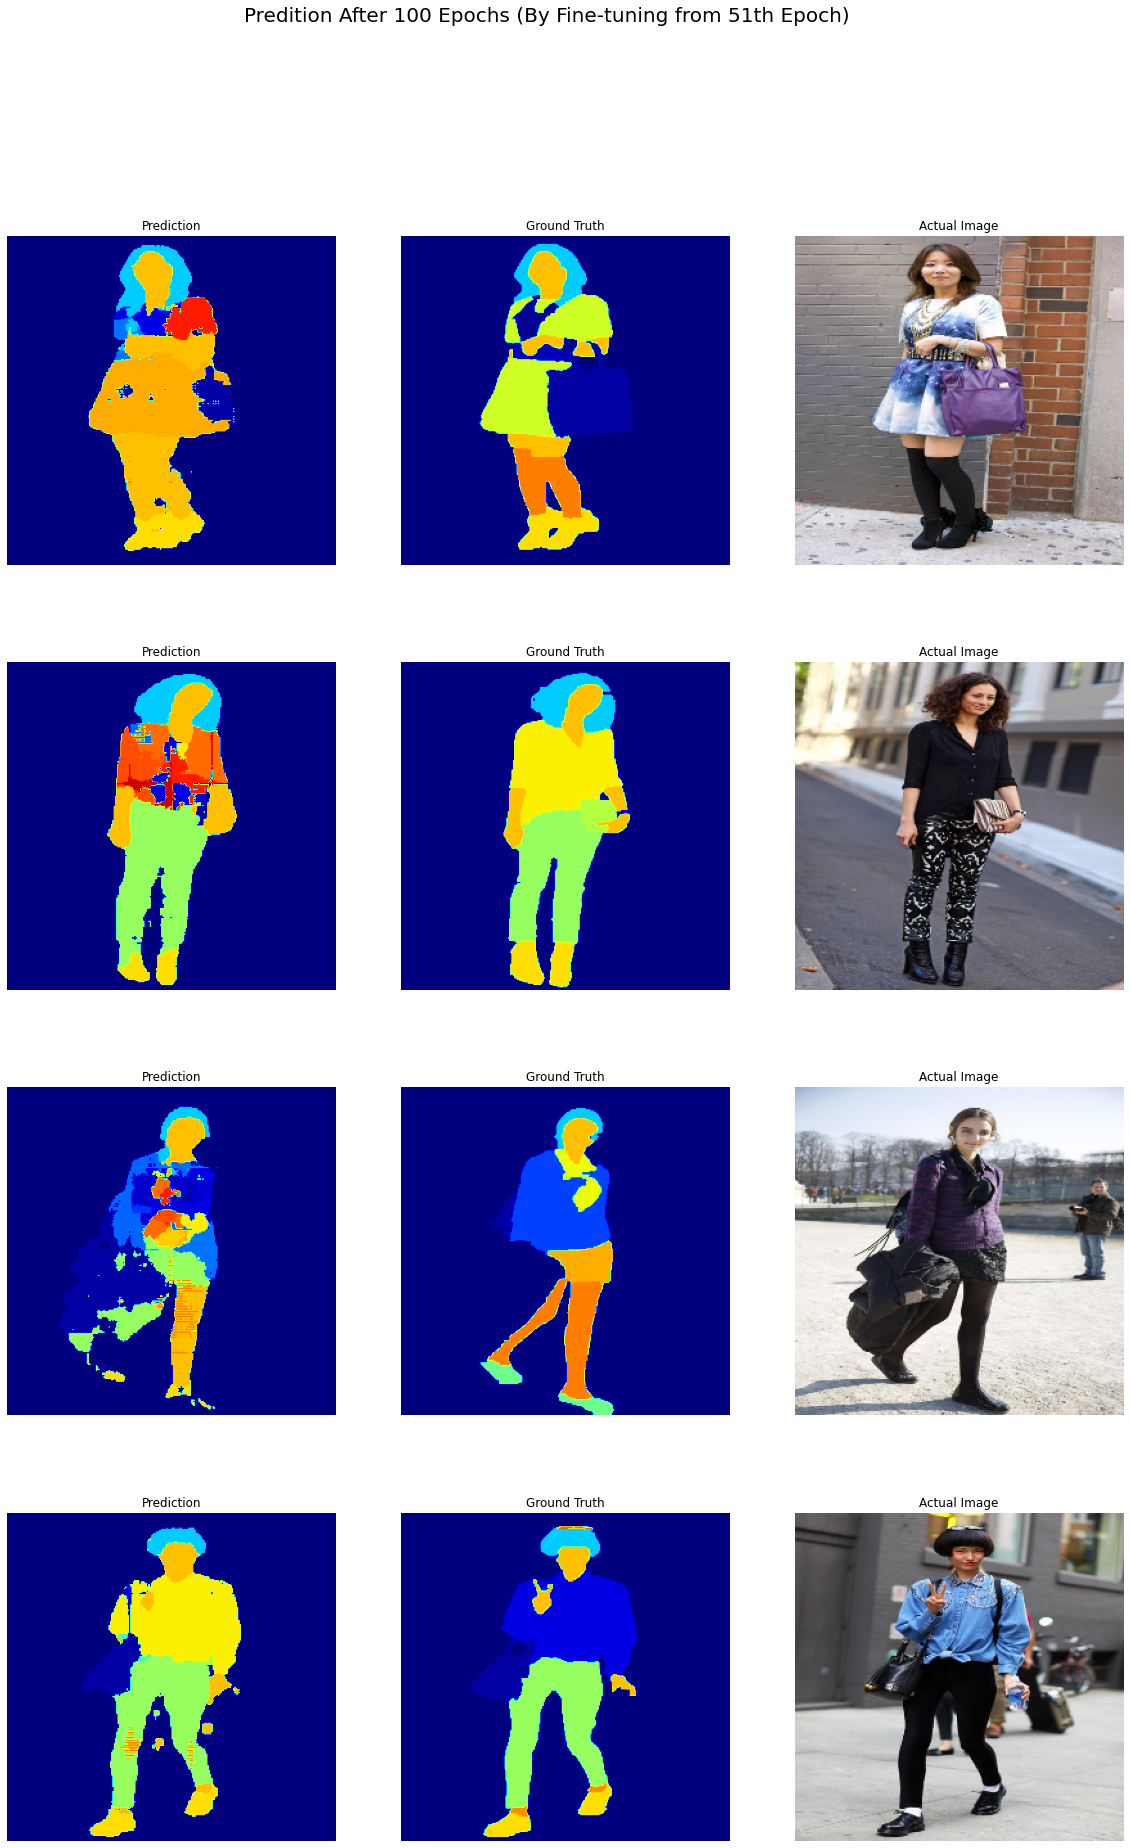

In [133]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = model.predict(img)
plt.figure(figsize=(20,30))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=norm)
    plt.axis('off')
    plt.title('Prediction')
    
    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(tf.squeeze(mask[k]), cmap='jet', norm=norm)
    plt.axis('off')
    plt.title('Ground Truth')
    
    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.suptitle('Predition After 100 Epochs (By Fine-tuning from 51th Epoch)', size=20)  
plt.show()

In [53]:
# model.save(os.path.join(os.path.pardir+os.sep+'models'+ os.sep,'model_DenseNet_100.h5'))

### Fine-tuning has improved the model performance significantly!

# Performance Curves

### Plot the performance curves to understand how the model learnt on the data 

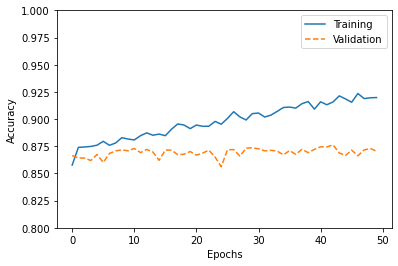

In [163]:
history_2 = hist_2.history
acc=history_2['accuracy']
val_acc = history_2['val_accuracy']

plt.plot(acc[:100], '-', label='Training')
plt.plot(val_acc[:100], '--', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.8,1.0])
plt.legend()
plt.show()

# Saving model

In [ ]:
mobilenet_save_path = os.path.pardi r+os.sep+ 'models'
tf.saved_model.save(unet, mobilenet_save_path)

In [ ]:
path_weights = os.path.pardir +os.sep+ 'models' +os.sep+ 'weights' +os.sep+ 'unet_weights.h5' 

In [ ]:
unet.save_weights(path_weights)